# Project 2.1 Data Cleanup

**The Business Problem**

Pawdacity is a leading pet store chain in Wyoming with 13 stores throughout the state. This year, Pawdacity would like to expand and open a 14th store. Your manager has asked you to perform an analysis to recommend the city for Pawdacity’s newest store, based on predicted yearly sales.

Your first step in predicting yearly sales is to first format and blend together data from different datasets and deal with outliers.

Your manager has given you the following information to work with:

<ol>
    <li>The monthly sales data for all of the Pawdacity stores for the year 2010. </li>
    <li>NAICS data on the most current sales of all competitor stores where total sales is equal to 12 months of sales. </li>
    <li>A partially parsed data file that can be used for population numbers. </li>
    <li>Demographic data (Households with individuals under 18, Land Area, Population Density, and Total Families) for each city and county in the state of Wyoming. For people who are unfamiliar with the US city system, a state contains counties and counties contains one or more cities.</li>
</ol>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

%matplotlib inline

In [2]:
df_sales = pd.read_csv("input/p2-2010-pawdacity-monthly-sales-p2-2010-pawdacity-monthly-sales.csv")
df_sales

,NAME,ADDRESS,CITY,STATE,ZIP,January,February,March,April,May,June,July,August,September,October,November,December
0,Pawdacity,509 Fort St # A,Buffalo,WY,82834,16200,13392,14688,17064,18360,14040,12960,19224,15984,13392,13176,16848
1,Pawdacity,601 SE Wyoming Blvd Unit 252,Casper,WY,82609,29160,21600,27000,27648,29160,27216,25488,25704,22896,25272,28944,27648
2,Pawdacity,3769 E Lincolnway,Cheyenne,WY,82001,79920,70632,79056,77544,73656,77976,73872,77544,78516,74520,74736,79920
3,Pawdacity,2625 Big Horn Ave,Cody,WY,82414,19440,15984,19008,18144,16632,17496,18792,20304,19224,18144,18576,16632
4,Pawdacity,123 S 2nd St,Douglas,WY,82633,16200,13392,14688,17064,18360,14040,12960,19224,15984,29808,17496,18792
5,Pawdacity,932 Main St,Evanston,WY,82930,24840,21168,21600,22248,24192,24624,25488,25704,22032,21168,25920,24840
6,Pawdacity,200 E Lakeway Rd,Gillette,WY,82718,47520,41796,48384,47088,42336,41904,42120,47088,49032,48168,42984,44712
7,Pawdacity,180 S Bent St,Powell,WY,82435,20520,17928,20304,21168,21600,17928,18144,18576,20304,21168,17496,18792
8,Pawdacity,512 E Main St,Riverton,WY,82501,27000,22032,28512,26784,25920,24192,25056,22896,25488,26352,26784,22248
9,Pawdacity,2706 Commercial Way,Rock Springs,WY,82901,21600,19872,22248,20952,17496,24840,22464,21816,21384,20304,22032,18576


In [3]:
df_scrape = pd.read_csv("input/p2-partially-parsed-wy-web-scrape.csv")
df_scrape

,City|County,2014 Estimate,2010 Census,2000 Census
0,Afton|Lincoln,"<td>1,968</td>","<td>1,911</td>","<td>1,818</td>"
1,Albin|Laramie,<td>185</td>,<td>181</td>,<td>120</td>
2,Alpine|Lincoln,<td>845</td>,<td>828</td>,<td>550</td>
3,Baggs|Carbon,<td>439</td>,<td>440</td>,<td>348</td>
4,Bairoil|Sweetwater,<td>107</td>,<td>106</td>,<td>97</td>
...,...,...,...,...
98,Yoder|Goshen,<td>161</td>,<td>151</td>,<td>169</td>
99,NaN,"<td colspan=""2""></td>","<td class=""navbox-abovebelow"" colspan=""2"">","<td colspan=""2""></td>"
100,NaN,"<td class=""navbox-list navbox-even hlist"" styl...","<td colspan=""2""></td>","<td class=""navbox-list navbox-odd hlist"" style..."
101,NaN,"<td colspan=""2""></td>","<td class=""navbox-list navbox-odd hlist"" style...","<td style=""padding:2px"">"


In [4]:
df_naics = pd.read_csv("input/p2-wy-453910-naics-data.csv", sep = ",", delimiter = ",")
df_naics

,"BUSINESS NAME,PHYSICAL CITY NAME,SALES VOLUME,CASS_LastLine"
0,"Mile High Mobile Pet LLC,Cheyenne,300000,""Chey..."
1,"Pets City Inc,Cheyenne,640000,""Cheyenne, WY 82..."
2,"Petco Animal Sups Stores Inc,Cheyenne,0,""Cheye..."
3,"Pet-A-Care,Cheyenne,81000,""Cheyenne, WY 82009-..."
4,"Muddy Paws Pet Salon,Laramie,76000,""Laramie, W..."
5,"Prossers Feed and Seed L L C,Wheatland,77000,""..."
6,"Pet Pals Inc of Goshen County,Torrington,12699..."
7,"Don Bruner Sales LLC,Torrington,750000,""Torrin..."
8,"Pals For Pets Inc,Saratoga,83000,""Saratoga, WY..."
9,"Pet Barn,Worland,69000,""Worland, WY 82401-2715"""


In [5]:
df_dmg = pd.read_csv("input/p2-wy-demographic-data.csv")
df_dmg

,City,County,Land Area,Households with Under 18,Population Density,Total Families
0,Laramie,Albany,2513.745235,2075,5.19,4668.93
1,Rock River,Albany,200.444000,165,0.41,372.30
2,Basin,Big Horn,543.951304,250,0.66,566.43
3,Burlington,Big Horn,137.646214,63,0.17,143.34
4,Byron,Big Horn,252.489592,116,0.31,262.93
...,...,...,...,...,...,...
94,Mountain View,Uinta,165.292453,246,0.82,448.60
95,Ten Sleep,Washakie,100.792517,46,0.17,106.26
96,Worland,Washakie,1294.105755,595,2.18,1364.32
97,Newcastle,Weston,1193.129216,386,1.47,957.04


### Finding out the sales for each city

In [6]:
df_sales_month = df_sales.iloc[:,5:].T
df_sales_month

,0,1,2,3,4,5,6,7,8,9,10
January,16200,29160,79920,19440,16200,24840,47520,20520,27000,21600,27000
February,13392,21600,70632,15984,13392,21168,41796,17928,22032,19872,26352
March,14688,27000,79056,19008,14688,21600,48384,20304,28512,22248,28080
April,17064,27648,77544,18144,17064,22248,47088,21168,26784,20952,22032
May,18360,29160,73656,16632,18360,24192,42336,21600,25920,17496,21168
June,14040,27216,77976,17496,14040,24624,41904,17928,24192,24840,29376
July,12960,25488,73872,18792,12960,25488,42120,18144,25056,22464,25920
August,19224,25704,77544,20304,19224,25704,47088,18576,22896,21816,20304
September,15984,22896,78516,19224,15984,22032,49032,20304,25488,21384,33696
October,13392,25272,74520,18144,29808,21168,48168,21168,26352,20304,23760


In [7]:
sales = df_sales_month.sum()
sales

0     185328
1     317736
2     917892
3     218376
4     208008
5     283824
6     543132
7     233928
8     303264
9     253584
10    308232
dtype: int64

In [8]:
df_sales_city = df_sales['CITY']
df_sales_2 = pd.concat([df_sales_city, sales], axis = 1)
df_sales_2.columns = ['City', 'Sales']
df_sales_2

,City,Sales
0,Buffalo,185328
1,Casper,317736
2,Cheyenne,917892
3,Cody,218376
4,Douglas,208008
5,Evanston,283824
6,Gillette,543132
7,Powell,233928
8,Riverton,303264
9,Rock Springs,253584


### Data cleaning 

Joining the cencus daata with sales data

In [9]:
df_scrape = df_scrape.dropna()

In [10]:
cities = df_scrape['City|County'].str.split("|")
city = [city for city, _ in cities]
city = [re.sub("[^a-zA-Z0-9 -]", "", c) for c in city]
city = [c.strip() for c in city]
print(city)

['Afton', 'Albin', 'Alpine', 'Baggs', 'Bairoil', 'Bar Nunn', 'Basin', 'Bear River', 'Big Piney', 'Buffalo', 'Burlington', 'Burns', 'Byron', 'Casper', 'Cheyenne', 'Chugwater', 'Clearmont', 'Cody', 'Cokeville', 'Cowley', 'Dayton', 'Deaver', 'Diamondville', 'Dixon', 'Douglas', 'Dubois', 'East Thermopolis', 'Edgerton', 'Elk Mountain', 'Evanston', 'Evansville', 'Fort Laramie', 'Frannie', 'Gillette', 'Glendo', 'Glenrock', 'Grand Encampment', 'Granger', 'Green River', 'Greybull', 'Guernsey', 'Hanna', 'Hartville', 'Hudson', 'Hulett', 'Jackson', 'Kaycee', 'Kemmerer', 'Kirby', 'La Barge', 'La Grange', 'Lander', 'Laramie', 'Lingle', 'Lost Springs', 'Lovell', 'Lusk', 'Lyman', 'Manderson', 'Manville', 'Marbleton', 'Medicine Bow', 'Meeteetse', 'Midwest', 'Mills', 'Moorcroft', 'Mountain View', 'Newcastle', 'Opal', 'Pavillion', 'Pine Bluffs', 'Pine Haven', 'Pinedale', 'Powell', 'Ranchester', 'Rawlins', 'Riverside', 'Riverton', 'Rock River', 'Rock Springs', 'Rolling Hills', 'Saratoga', 'Sheridan', 'Sho

In [11]:
census2010 = df_scrape['2010 Census'].str.replace(",","")
census2010 = [int(re.sub("[^0-9]", "", c)) for c in census2010]
print(census2010)

[1911, 181, 828, 440, 106, 2213, 1285444, 518, 552, 4585, 288, 301, 593, 35316, 59466, 212, 142, 9520, 535, 655, 757, 178, 737, 97, 6120, 971, 254, 195, 191, 12359, 2544, 230, 157, 29087, 205, 2576, 450, 139, 12515, 1847, 1147, 841, 62, 458, 383, 9577, 263, 2656, 92, 551, 448, 7487, 30816, 468, 4, 2360, 1567, 2115, 114, 95, 1094, 284, 327, 404, 3461, 1009, 1286, 3532, 96, 231, 1129, 490, 2030, 6314, 855, 9259, 52, 10615, 245, 23036, 440, 1690, 17444, 649, 433, 1503, 1182, 336, 260, 366555, 3009, 6501, 1100, 15, 451, 3627, 5487, 1807, 151]


In [12]:
df_census = pd.DataFrame({'City': city, 'Census2010': census2010})
df_census.head()

,City,Census2010
0,Afton,1911
1,Albin,181
2,Alpine,828
3,Baggs,440
4,Bairoil,106


In [13]:
# add Census2014 we will need in the predictive part
census2014 = df_scrape['2014 Estimate'].str.replace(",","")
census2014 = [int(re.sub("[^0-9]", "", c)) for c in census2014]
df_census_2014 = pd.DataFrame({'City': city, 'Census2014': census2014})
df_census_2014.head()

,City,Census2014
0,Afton,1968
1,Albin,185
2,Alpine,845
3,Baggs,439
4,Bairoil,107


#### Join `df_sales_2` and `df_census`

In [14]:
df = pd.merge(df_sales_2, df_census, on='City', how='inner')
df

,City,Sales,Census2010
0,Buffalo,185328,4585
1,Casper,317736,35316
2,Cheyenne,917892,59466
3,Cody,218376,9520
4,Douglas,208008,6120
5,Evanston,283824,12359
6,Gillette,543132,29087
7,Powell,233928,6314
8,Riverton,303264,10615
9,Rock Springs,253584,23036


In [15]:
df_2014 = pd.merge(df_sales_2, df_census_2014, on='City', how='inner')
df_2014

,City,Sales,Census2014
0,Buffalo,185328,4615
1,Casper,317736,40086
2,Cheyenne,917892,62845
3,Cody,218376,9740
4,Douglas,208008,6423
5,Evanston,283824,12190
6,Gillette,543132,31971
7,Powell,233928,6407
8,Riverton,303264,10953
9,Rock Springs,253584,24045


#### Adding demographic data

In [16]:
df_cleaned = pd.merge(df, df_dmg, on='City', how='inner')
df = df_cleaned.drop('County', axis=1)

In [17]:
df.columns = ['City', 'Sales', 'Census2010', 'Land_area', 'Households_U18', 'Pop_density', 'Families']
df

,City,Sales,Census2010,Land_area,Households_U18,Pop_density,Families
0,Buffalo,185328,4585,3115.507500,746,1.55,1819.50
1,Casper,317736,35316,3894.309100,7788,11.16,8756.32
2,Cheyenne,917892,59466,1500.178400,7158,20.34,14612.64
3,Cody,218376,9520,2998.956960,1403,1.82,3515.62
4,Douglas,208008,6120,1829.465100,832,1.46,1744.08
5,Evanston,283824,12359,999.497100,1486,4.95,2712.64
6,Gillette,543132,29087,2748.852900,4052,5.80,7189.43
7,Powell,233928,6314,2673.574550,1251,1.62,3134.18
8,Riverton,303264,10615,4796.859815,2680,2.34,5556.49
9,Rock Springs,253584,23036,6620.201916,4022,2.78,7572.18


In [18]:
df.sum()

City              BuffaloCasperCheyenneCodyDouglasEvanstonGillet...
Sales                                                       3773304
Census2010                                                   213862
Land_area                                              33071.380389
Households_U18                                                34064
Pop_density                                                    62.8
Families                                                   62652.79
dtype: object

In [19]:
df.mean()

Sales             343027.636364
Census2010         19442.000000
Land_area           3006.489126
Households_U18      3096.727273
Pop_density            5.709091
Families            5695.708182
dtype: float64

## Checking the outliers

<AxesSubplot:>

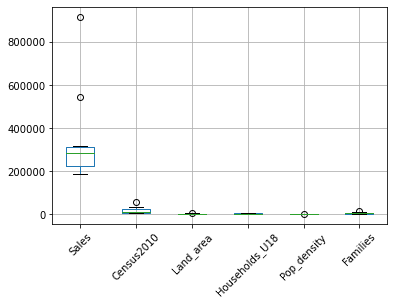

In [20]:
df.boxplot(rot=45)

<Figure size 864x720 with 0 Axes>

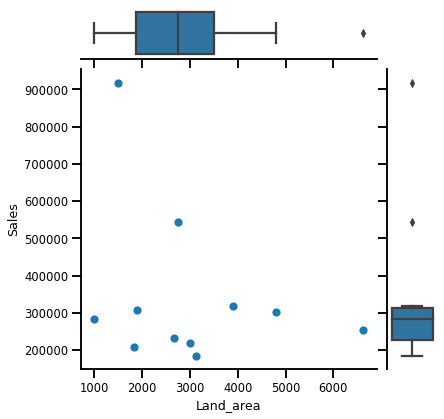

In [21]:
# set plot context to set plot sizes 
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(12,10))
g = sns.JointGrid(data=df, 
                  x="Land_area",
                  y="Sales")
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.boxplot)
# plt.savefig("Scatterplot_with_marginal_boxplot_Seaborn.png",
#                     format='png',dpi=150)
plt.show()

<Figure size 864x720 with 0 Axes>

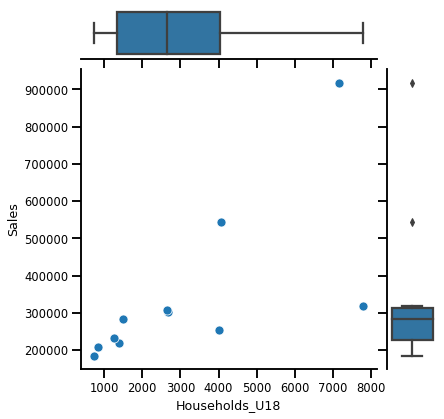

In [22]:
# set plot context to set plot sizes 
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(12,10))
g = sns.JointGrid(data=df, 
                  x="Households_U18",
                  y="Sales")
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.boxplot)
# plt.savefig("Scatterplot_with_marginal_boxplot_Seaborn.png",
#                     format='png',dpi=150)
plt.show()

<Figure size 864x720 with 0 Axes>

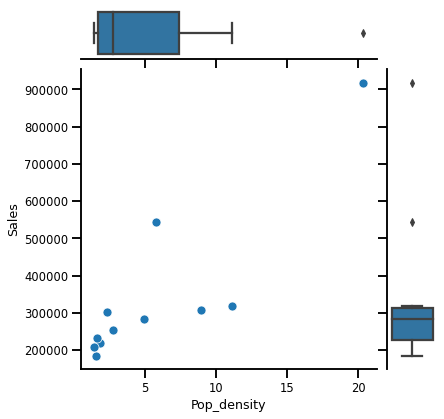

In [23]:
# set plot context to set plot sizes 
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(12,10))
g = sns.JointGrid(data=df, 
                  x="Pop_density",
                  y="Sales")
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.boxplot)
# plt.savefig("Scatterplot_with_marginal_boxplot_Seaborn.png",
#                     format='png',dpi=150)
plt.show()

<Figure size 864x720 with 0 Axes>

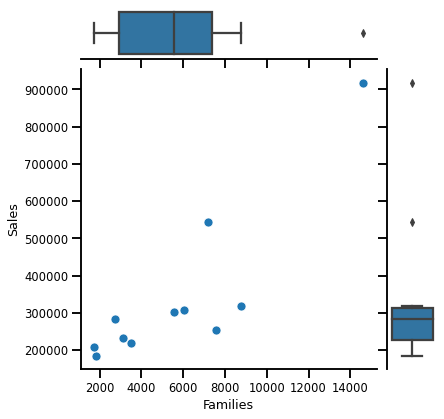

In [24]:
# set plot context to set plot sizes 
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(12,10))
g = sns.JointGrid(data=df, 
                  x="Families",
                  y="Sales")
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.boxplot)
# plt.savefig("Scatterplot_with_marginal_boxplot_Seaborn.png",
#                     format='png',dpi=150)
plt.show()

<Figure size 864x720 with 0 Axes>

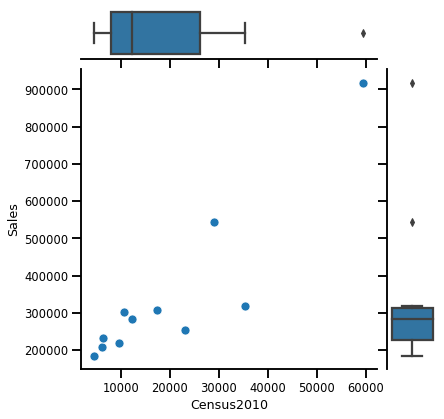

In [25]:
# set plot context to set plot sizes 
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(12,10))
g = sns.JointGrid(data=df, 
                  x="Census2010",
                  y="Sales")
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.boxplot)
# plt.savefig("Scatterplot_with_marginal_boxplot_Seaborn.png",
#                     format='png',dpi=150)
plt.show()

## Regression Model

In [26]:
# checking for correlations between  predictor variables to avoid multicollinearity
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Census2010,Land_area,Households_U18,Pop_density,Families
Sales,1.00,0.90,-0.29,0.68,0.86,0.86
Census2010,0.90,1.00,-0.06,0.91,0.93,0.97
Land_area,-0.29,-0.06,1.00,0.18,-0.32,0.10
Households_U18,0.68,0.91,0.18,1.00,0.82,0.91
Pop_density,0.86,0.93,-0.32,0.82,1.00,0.88
Families,0.86,0.97,0.10,0.91,0.88,1.00


In [27]:
#Correlation with output variable
cor_target = abs(corr["Sales"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.4]
df_corr = pd.DataFrame(relevant_features)

df_corr = df_corr.reset_index()
df_corr = df_corr.rename(columns = {'Sales' : 'Corr'})
df_corr = df_corr.sort_values(['Corr'], ascending=False)
df_corr

,index,Corr
0,Sales,1.000000
1,Census2010,0.898099
4,Families,0.864660
3,Pop_density,0.862894
2,Households_U18,0.676012


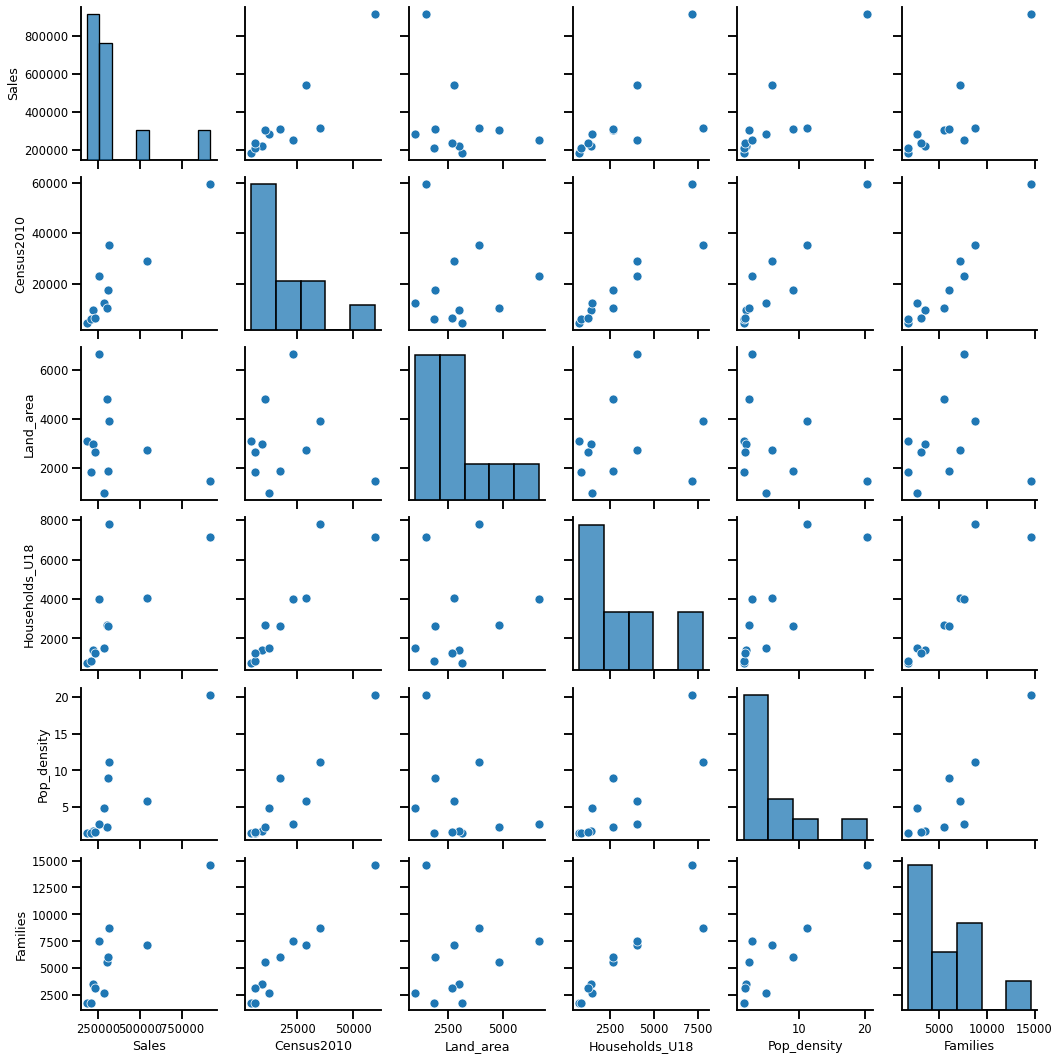

In [28]:
sns.pairplot(df);

In [29]:
#Let's check VIFs. if >10 (rule of thumb), then multicollinearity in the model
y, X = dmatrices('Sales ~ Census2010 + Land_area + Households_U18 + Pop_density + Families', df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,13.883065,Intercept
1,44.444269,Census2010
2,9.690223,Land_area
3,13.714860,Households_U18
4,29.380286,Pop_density
5,51.003038,Families


In [30]:
# let's remove Census2010 to see if multicollinearity diminishes
y, X = dmatrices('Sales ~ Land_area + Households_U18 + Families', df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,7.102241,Intercept
1,1.059556,Land_area
2,5.929994,Households_U18
3,5.793586,Families


In [31]:
df['intercept'] = 1
lm = sm.OLS(df['Sales'], df[['Land_area','Households_U18', 'Families', 'Pop_density', 'intercept']])
results = lm.fit()
results.summary()

C:\Users\hamzahf\.conda\envs\ML\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     30.40
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           0.000401
Time:                        12:34:43   Log-Likelihood:                -133.26
No. Observations:                  11   AIC:                             276.5
Df Residuals:                       6   BIC:                             278.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Land_area        -97.6305     29.297     -3.332      0.016    -169.319     -25.942
Households_U18   -14.5207     22.270     -0.652      0.539     -69.013      39.972
Families         106.4794     20.840      5.109      0.002      55.486     157.473
Pop_density    -3.356e+04   1.69e+04     -1.983      0.095    -7.5e+04    7859.821
intercept       2.666e+05   6.41e+04      4.158      0.006     1.1e+05    4.24e+05
==============================================================================
Omnibus:                        0.559   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.155
Skew:                           0.268   Prob(JB):                        0.926
Kurtosis:                       2.775   Cond. No.                     2.97e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
lm1 = sm.OLS(df['Sales'], df[['Land_area', 'Families', 'Pop_density', 'intercept']])
results = lm1.fit()
results.summary()

C:\Users\hamzahf\.conda\envs\ML\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     44.00
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           6.54e-05
Time:                        12:34:43   Log-Likelihood:                -133.63
No. Observations:                  11   AIC:                             275.3
Df Residuals:                       7   BIC:                             276.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Land_area    -108.4368     23.146     -4.685      0.002    -163.168     -53.705
Families      106.5242     19.966      5.335      0.001      59.313     153.736
Pop_density  -3.95e+04   1.37e+04     -2.890      0.023   -7.18e+04   -7182.540
intercept    2.878e+05    5.3e+04      5.434      0.001    1.63e+05    4.13e+05
==============================================================================
Omnibus:                        2.164   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                0.924
Skew:                           0.709   Prob(JB):                        0.630
Kurtosis:                       2.921   Cond. No.                     2.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
lm1 = sm.OLS(df['Sales'], df[['Land_area', 'Families', 'Pop_density', 'intercept']])
results = lm1.fit()
results.summary()

C:\Users\hamzahf\.conda\envs\ML\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     44.00
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           6.54e-05
Time:                        12:34:44   Log-Likelihood:                -133.63
No. Observations:                  11   AIC:                             275.3
Df Residuals:                       7   BIC:                             276.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Land_area    -108.4368     23.146     -4.685      0.002    -163.168     -53.705
Families      106.5242     19.966      5.335      0.001      59.313     153.736
Pop_density  -3.95e+04   1.37e+04     -2.890      0.023   -7.18e+04   -7182.540
intercept    2.878e+05    5.3e+04      5.434      0.001    1.63e+05    4.13e+05
==============================================================================
Omnibus:                        2.164   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                0.924
Skew:                           0.709   Prob(JB):                        0.630
Kurtosis:                       2.921   Cond. No.                     2.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""